In [2]:
import cv2
from torchvision import datasets, transforms, models
from PIL import Image,ImageDraw
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [3]:
device="cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# Model-LeNet 
## Accuracy- 97(train), 96(val)

In [6]:
transform= transforms.Compose([transforms.Resize((32,32)), 
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5),(0.5))])
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1,5*5*16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model=torch.load("model/mask_detect_LeNet(accuracy 99%).pth")

In [11]:
capture= cv2.VideoCapture(0)
labels=["Not Wearing a Mask", "Wearing mask"]
font = cv2.FONT_HERSHEY_DUPLEX
size=4
color=[(10,0,255),(10,255,0)]
classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

while True:
    ret,frame=capture.read()
    frame=cv2.flip(frame,1,1)
    gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    mini = cv2.resize(frame, (frame.shape[1] // size, frame.shape[0] // size))
    faces = classifier.detectMultiScale(mini)
    if len(faces)==0:
        cv2.putText(frame,"No face found",(30,30), font, 1.0, color[0], 1)
    for f in faces:
        (x,y,w,h) = [v*size for v in f ]
        crop=frame[y:y+h,x:x+w]
        pil_image = Image.fromarray(crop,mode="RGB")
        
        output=model(transform(pil_image).to(device).unsqueeze(0))
        a,pred=torch.max(output.data,1)
        percentage = str(int(output.data[0,1]*100))
        amount = str(int(output.data[0,1]*100)-100)
        if (percentage>"100") and pred==1:
            percentage="100"
        elif percentage>"0" and pred==0:
            percentage=amount
        elif percentage<"0" and pred==0:
            percentage="0"
        cv2.rectangle(frame, (x, y), (x+w, y+h),color[pred], 2)
        #plt.imshow(pil_image)
        cv2.putText(frame,percentage+" % " +labels[pred], (x, y-10), font, 1.0, color[pred], 1)
    cv2.imshow('Face Mask Detection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
capture.release()
cv2.destroyAllWindows()

# Crowd testing

error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-i1s8y2i1\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


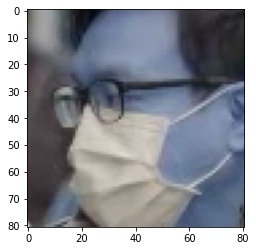

In [10]:
cam = cv2.VideoCapture("output.mp4")
face_detector=cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
if (face_detector.empty()) :
    print ("No faces found ")
    quit()
while(True):
    
    ret, img = cam.read()
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_detector.detectMultiScale(gray, 1.5, 5)
    for (x,y,w,h) in faces:
        crop=img[y:y+h,x:x+w]
        pil_image = Image.fromarray(crop,mode="RGB")
        
        output=model(transform(pil_image).to(device).unsqueeze(0))
        a,pred=torch.max(output.data,1)
        cv2.rectangle(img, (x, y), (x+w, y+h),color[pred], 2)
        cv2.putText(img,labels[pred], (x, y-10), font, 1.0, color[pred], 1)
        plt.imshow(pil_image)

    cv2.imshow('frame',img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cam.release()
cv2.destroyAllWindows()